In [8]:
!pip install pyspark

In [9]:
from pyspark.sql import SparkSession
import requests
from io import StringIO
import pandas as pd
from google.colab import drive
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, col, row_number
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.sql.types import StructType, StructField, ArrayType, DoubleType
import numpy as np
spark = SparkSession.builder \
    .appName("MapReduce k-NN") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "2000m") \
    .getOrCreate()

In [10]:
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Big data/df_final.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# df = spark.read.csv(file_path, header=True, inferSchema=True)
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show()

+----------+-------------------------------------+-------------------------------------+--------------------------+--------------------------+---------------+
|is_injured|contributing_factor_vehicle_1_encoded|contributing_factor_vehicle_2_encoded|vehicle_type_code1_encoded|vehicle_type_code2_encoded|borough_encoded|
+----------+-------------------------------------+-------------------------------------+--------------------------+--------------------------+---------------+
|         0|                                 36.0|                                 21.0|                      32.0|                      37.0|            3.0|
|         1|                                  7.0|                                 21.0|                      32.0|                      37.0|            0.0|
|         1|                                  7.0|                                 21.0|                      32.0|                      38.0|            1.0|
|         0|                                  

In [12]:
feature_columns = [
    "contributing_factor_vehicle_1_encoded", "contributing_factor_vehicle_2_encoded",
    "vehicle_type_code1_encoded", "vehicle_type_code2_encoded", "borough_encoded"
]

# Dùng VectorAssembler để kết hợp các feature thành 1 cột duy nhất
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
df = scaler.fit(df).transform(df)
df.show()

+----------+-------------------------------------+-------------------------------------+--------------------------+--------------------------+---------------+--------------------+--------------------+
|is_injured|contributing_factor_vehicle_1_encoded|contributing_factor_vehicle_2_encoded|vehicle_type_code1_encoded|vehicle_type_code2_encoded|borough_encoded|            features|     scaled_features|
+----------+-------------------------------------+-------------------------------------+--------------------------+--------------------------+---------------+--------------------+--------------------+
|         0|                                 36.0|                                 21.0|                      32.0|                      37.0|            3.0|[36.0,21.0,32.0,3...|[1.30800416442327...|
|         1|                                  7.0|                                 21.0|                      32.0|                      37.0|            0.0|[7.0,21.0,32.0,37...|[-1.0655656701277

In [13]:
df = df.select("scaled_features", "is_injured")

In [14]:
df.show()

+--------------------+----------+
|     scaled_features|is_injured|
+--------------------+----------+
|[1.30800416442327...|         0|
|[-1.0655656701277...|         1|
|[-1.0655656701277...|         1|
|[-1.5566490841727...|         0|
|[0.98061522172658...|         1|
|[-1.0655656701277...|         0|
|[-1.0655656701277...|         0|
|[1.30800416442327...|         1|
|[1.30800416442327...|         0|
|[-1.4748018484985...|         0|
|[-1.0655656701277...|         0|
|[-1.0655656701277...|         0|
|[1.30800416442327...|         1|
|[0.57137904335571...|         1|
|[-1.0655656701277...|         1|
|[-1.4748018484985...|         0|
|[1.30800416442327...|         0|
|[1.30800416442327...|         1|
|[-0.4926350204085...|         0|
|[-1.0655656701277...|         0|
+--------------------+----------+
only showing top 20 rows



In [15]:
import numpy as np
import math
from pyspark.sql import SparkSession

train, test = df.randomSplit([0.8, 0.2], seed=42)

train_rdd = train.rdd.map(lambda row: (np.array(row['scaled_features']), row['is_injured']))

test_rdd = test.rdd.zipWithIndex().map(
    lambda row_index: (row_index[1], (np.array(row_index[0]['scaled_features']), row_index[0]['is_injured']))
)



In [16]:
shards = train_rdd.randomSplit([1.0 / 3] * 3, seed=42)
for i, shard in enumerate(shards):
    print(f"Shard {i}: {shard.take(5)}")

Shard 0: [(array([-1.63849632, -2.76288657,  0.37699112,  1.36280042, -0.57939038]), 1), (array([-1.63849632,  0.43690897,  0.37699112,  0.4423966 , -0.57939038]), 1), (array([-1.55664908,  0.43690897, -2.37747776,  0.4423966 , -0.57939038]), 0), (array([-1.55664908,  0.43690897, -0.80349554,  0.4423966 , -1.48764722]), 1), (array([-1.55664908,  0.43690897,  0.37699112,  0.52606967,  1.2371233 ]), 0)]
Shard 1: [(array([-1.55664908,  0.43690897, -2.47585165,  0.4423966 ,  1.2371233 ]), 0), (array([-1.55664908,  0.43690897,  0.37699112,  0.4423966 , -0.57939038]), 0), (array([-1.55664908,  0.43690897,  0.37699112,  0.52606967, -0.57939038]), 0), (array([-1.55664908,  0.43690897,  0.47536501, -0.47800722, -0.57939038]), 1), (array([-1.47480185, -2.76288657,  0.37699112,  0.4423966 , -1.48764722]), 0)]
Shard 2: [(array([-1.55664908,  0.43690897,  0.47536501,  0.4423966 , -0.57939038]), 1), (array([-1.55664908,  0.43690897,  0.86886056, -2.23514179, -1.48764722]), 1), (array([-1.55664908,  

In [17]:
def euclidean_distance(x, y):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(x, y)))

In [18]:
combined_result = spark.sparkContext.emptyRDD()

for i, shard in enumerate(shards):
    result = test_rdd.cartesian(shard).map(
        lambda pair: (
            pair[0][0],
            (pair[0][1][1], (euclidean_distance(pair[0][1][0], pair[1][0]), pair[1][1]))  # (Test label, (distance, train label))
        )
    )
    #emit:  test_id, (test_label, (distance, train_label))
    combined_result = combined_result.union(result)
#In ra để Debug
debug_combined_result = combined_result.take(5)
for test_id, (test_label, (distance, train_label)) in debug_combined_result:
    print(f"Test ID: {test_id}, Test Label: {test_label}, Distance: {distance}, Train Label: {train_label}")

Test ID: 0, Test Label: 0, Distance: 4.286357621604302, Train Label: 1
Test ID: 0, Test Label: 0, Distance: 2.7278293552687667, Train Label: 1
Test ID: 0, Test Label: 0, Distance: 3.94674377038589, Train Label: 0
Test ID: 0, Test Label: 0, Distance: 3.853319641347675, Train Label: 1
Test ID: 0, Test Label: 0, Distance: 0.9172278229918879, Train Label: 0


In [19]:
#In ra để Debug
for i, shard in enumerate(shards):
    shard_count = shard.count()
    result = test_rdd.cartesian(shard)
    print(f"Shard {i}: Test x Shard Cartesian Count = {result.count()} (Test: {test_rdd.count()}, Shard: {shard_count})")


Shard 0: Test x Shard Cartesian Count = 52096 (Test: 176, Shard: 296)
Shard 1: Test x Shard Cartesian Count = 49808 (Test: 176, Shard: 283)
Shard 2: Test x Shard Cartesian Count = 52800 (Test: 176, Shard: 300)


In [20]:
k = 3
#Shuffling: groupbyKey
top_k_neighbors = combined_result.groupByKey().mapValues(
    lambda neighbors: sorted(neighbors, key=lambda x: x[1][0])[:k]  # Sorting
)

predictions = top_k_neighbors.mapValues(
    lambda neighbors: max(
        set([n[1][1] for n in neighbors]),
        key=[n[1][1] for n in neighbors].count
    )
)

In [21]:
# Ví dụ: Danh sách k điểm gần nhất trên tập train tương ứng với test_id
top_k_neighbors_sample = top_k_neighbors.take(1)
top_k_neighbors_sample

[(0,
  [(0, (0.37257860201963644, 1)),
   (0, (0.5729306497192082, 1)),
   (0, (0.5729306497192082, 0))])]

In [22]:
# Ví dụ: kết quả sao khi chọn nhãn nhiều nhất
predictions_sample = predictions.take(1)
predictions_sample

[(0, 1)]

In [23]:
# lấy true_label
test_rdd_with_id = test_rdd.map(lambda x: (x[0], x[1][1]))

test_labels_df = spark.createDataFrame(test_rdd_with_id, ["test_id", "true_label"])
predictions_df = spark.createDataFrame(predictions, ["test_id", "predicted_label"])

# merge y_test & y_pred
result_df = predictions_df.join(test_labels_df, on="test_id")


In [24]:
# Define a function to calculate evaluation metrics
def calculate_metrics(result_df):
    result_rdd = result_df.rdd.map(lambda row: (row.true_label, row.predicted_label))

    # Calculate metrics
    tp = result_rdd.filter(lambda x: x == (1, 1)).count()
    tn = result_rdd.filter(lambda x: x == (0, 0)).count()
    fp = result_rdd.filter(lambda x: x == (0, 1)).count()
    fn = result_rdd.filter(lambda x: x == (1, 0)).count()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
    }


In [25]:
metrics = calculate_metrics(result_df)
print("\nValidation Metrics:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")


Validation Metrics:
Accuracy: 0.4318
Precision: 0.3418
Recall: 0.3600
F1_score: 0.3506


In [26]:
best_accuracy = 0.0
best_k = 0
results = []

for k in range(1, 32,2):
    # Shuffling: groupbyKey
    top_k_neighbors = combined_result.groupByKey().mapValues(
        lambda neighbors: sorted(neighbors, key=lambda x: x[1][0])[:k]  # Sorting
    )

    predictions = top_k_neighbors.mapValues(
        lambda neighbors: max(
            set([n[1][1] for n in neighbors]),
            key=[n[1][1] for n in neighbors].count
        )
    )

    test_rdd_with_id = test_rdd.map(lambda x: (x[0], x[1][1]))
    test_labels_df = spark.createDataFrame(test_rdd_with_id, ["test_id", "true_label"])
    predictions_df = spark.createDataFrame(predictions, ["test_id", "predicted_label"])

    result_df = predictions_df.join(test_labels_df, on="test_id")

    metrics = calculate_metrics(result_df)
    accuracy = metrics['accuracy']

    results.append((k, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
for k, accuracy in results:
    print(f"k = {k}, Accuracy = {accuracy}")




k = 1, Accuracy = 0.4375
k = 3, Accuracy = 0.4318181818181818
k = 5, Accuracy = 0.4375
k = 7, Accuracy = 0.4715909090909091
k = 9, Accuracy = 0.48295454545454547
k = 11, Accuracy = 0.4602272727272727
k = 13, Accuracy = 0.4431818181818182
k = 15, Accuracy = 0.4375
k = 17, Accuracy = 0.44886363636363635
k = 19, Accuracy = 0.45454545454545453
k = 21, Accuracy = 0.42045454545454547
k = 23, Accuracy = 0.4147727272727273
k = 25, Accuracy = 0.4375
k = 27, Accuracy = 0.44886363636363635
k = 29, Accuracy = 0.4431818181818182
k = 31, Accuracy = 0.4602272727272727


In [27]:
print(f"Best k: {best_k} with Accuracy: {best_accuracy}")


Best k: 9 with Accuracy: 0.48295454545454547


In [32]:
k = 9
#Shuffling: groupbyKey
top_k_neighbors = combined_result.groupByKey().mapValues(
    lambda neighbors: sorted(neighbors, key=lambda x: x[1][0])[:k]  # Sorting
)

predictions = top_k_neighbors.mapValues(
    lambda neighbors: max(
        set([n[1][1] for n in neighbors]),
        key=[n[1][1] for n in neighbors].count
    )
)

In [33]:
# lấy true_label
test_rdd_with_id = test_rdd.map(lambda x: (x[0], x[1][1]))

test_labels_df = spark.createDataFrame(test_rdd_with_id, ["test_id", "true_label"])
predictions_df = spark.createDataFrame(predictions, ["test_id", "predicted_label"])

# merge y_test & y_pred
result_df = predictions_df.join(test_labels_df, on="test_id")


In [34]:
metrics = calculate_metrics(result_df)
print("\nValidation Metrics:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")


Validation Metrics:
Accuracy: 0.4830
Precision: 0.3974
Recall: 0.4133
F1_score: 0.4052


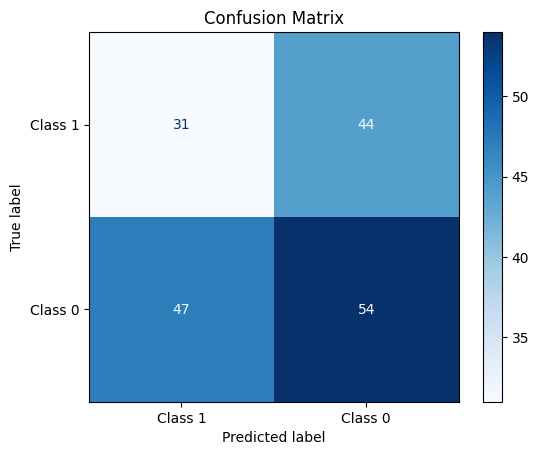

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
result_pd = result_df.toPandas()
y_true = result_pd["true_label"].values
y_pred = result_pd["predicted_label"].values
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 1", "Class 0"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
